# Net_sonar

## Dataset setup


Creation and setup of this dataset is done in [net_sonar_dataset_creation.ipynb](../../solaqua/notebooks/net_sonar_dataset_creation.ipynb)

# Building

Building (and training) of the model happens in [train.py](../train.py). The model is constructed by the [aquayolo.yaml](../models/aquayolo.yaml), that imports modules from custom blocks (see paragraph below).

### Adding custom blocks

I have added custom blocks to match the architecture as pruposed in the paper. For this to work I have first cloned the ultralytics repo.
- Head to [ultralytics](https://docs.ultralytics.com/guides/model-yaml-config/#source-code-modification) to see how to add custom blocks.
- Files that is modified: [block.py](../../ultralytics/ultralytics/nn/modules/block.py) (classes: AquaResidualBlock, DSAM), [tasks.py](../../ultralytics/ultralytics/nn/tasks.py) (added imports and updated parse_model() for special arguments), [__init__.py](../../ultralytics/ultralytics/nn/modules/__init__.py) (exposing the modules).



# Training

- To train the model run the train.py script by doing: `python3 train.py`

Train.py script:

```bash

# train.py
from ultralytics import YOLO


if __name__ == "__main__":
    
    # Load custom model cfg
    m = YOLO("models/aquayolo.yaml")
    m.info()  # non-zero FLOPs confirms forward path OK

    m.train(
        data="../solaqua/data/net_sonar/net_sonar.yaml",
        pretrained=False,          # Safest off
        epochs=150, 
        patience=50,   
        imgsz=1280,
        batch=12,
        nbs=64,

    # optimizer 
        optimizer="SGD",
        lr0=0.005,                      # conservative for SGD; adjust later if needed
        momentum=0.9,
        weight_decay=5e-4,
        cos_lr=True,
        lrf=0.01,
        warmup_epochs=20,     
                 


    # loss balance – tilt a bit toward recall ????
        box=10.0, cls=0.6, dfl=1.3,


    # augmentation, all off
        rect=True,
        mosaic=0.0,
        mixup=0.0,
        copy_paste=0.0,
        erasing=0.0,
        auto_augment=None,
        hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
        degrees=0.0, shear=0.0, perspective=0.0,
        translate=0.0,            # turn off to be maximally safe
        scale=0.0,                # turn off to be maximally safe
        fliplr=0.0, flipud=0.0,
    

        
    # system
        workers=2,                 # safe
        device=0,
        project="runs_aquayolo",
        name="net_sonar_SGD_1280_verysafe",
        seed=0,
        plots=False,
        cache=False,
        amp=False,   
    )

    #light_aug variant:
    # augmentation, light
        rect=False,
        mosaic=0.08,
        close_mosaic=100, # only on for the 50 first. 
        mixup=0.05,
        copy_paste=0.0,
        erasing=0.0,
        auto_augment=None,
        hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
        degrees=3.0, shear=0.0, perspective=0.0,
        translate=0.06,
        scale=0.20,
        fliplr=0.0, flipud=0.0,
    
```



### How I did training

- Using the IDUN computer at NTNU. 
    - Idun settings: 1 GPUS (H100). 32 CPU cores, 64 GB RAM, 



# Evaluation

In [ ]:
# no augmentation
from ultralytics import YOLO
model = YOLO("../runs_aquayolo/net_sonar_adamW_1280_verysafe/weights/best.pt")
results = model.val(
    data="../../solaqua/data/net_sonar/net_sonar.yaml", # remember to change to test 
    imgsz=1280,
    batch=1,
    iou=0.7,    # intersection over union treshold 
    plots=True,
    project="../runs_aquayolo",
    name="EVAL_net_sonar_adamW_1280_verysafe",
    exist_ok=True
)


Ultralytics 8.3.213 🚀 Python-3.9.21 torch-2.8.0+cu128 CUDA:0 (NVIDIA H100 80GB HBM3, 81079MiB)
aquaYOLO summary: 301 layers, 56,841,107 parameters, 0 gradients, 169.2 GFLOPs
val: Fast image access ✅ (ping: 10.6±9.8 ms, read: 5.4±1.5 MB/s, size: 65.2 KB)
val: Scanning /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_sonar/labels/test... 400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 400/400 250.2it/s 1.6s0.0s
val: New cache created: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_sonar/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 400/400 84.4it/s 4.7s<0.0s
                   all        400        400      0.916      0.897      0.921      0.511
Speed: 0.2ms preprocess, 9.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/runs_aquayolo/EVAL_net_sonar_adamW_1280_verysafe


In [ ]:
# some conservative augmentation
from ultralytics import YOLO
model = YOLO("../runs_aquayolo/net_sonar_SGD_1280_lightaug/weights/best.pt")
results = model.val(
    data="../../solaqua/data/net_sonar/net_sonar.yaml", # remember to change to test 
    imgsz=1280,
    batch=1,
    iou=0.7,    # intersection over union treshold 
    plots=True,
    project="../runs_aquayolo",
    name="EVAL_net_sonar_SGD_1280_lightaug",
    exist_ok=True
)


Ultralytics 8.3.213 🚀 Python-3.9.21 torch-2.8.0+cu128 CUDA:0 (NVIDIA H100 80GB HBM3, 81079MiB)
aquaYOLO summary: 301 layers, 56,841,107 parameters, 0 gradients, 169.2 GFLOPs
val: Fast image access ✅ (ping: 11.4±11.3 ms, read: 10.3±2.2 MB/s, size: 65.0 KB)
val: Scanning /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/net_sonar/labels/test.cache... 400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 400/400 614.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 400/400 69.4it/s 5.8s<0.0s
                   all        400        400      0.942      0.929      0.943      0.575
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/runs_aquayolo/EVAL_net_sonar_adamW_1280_lightaug


### Show Evaluation Metrics

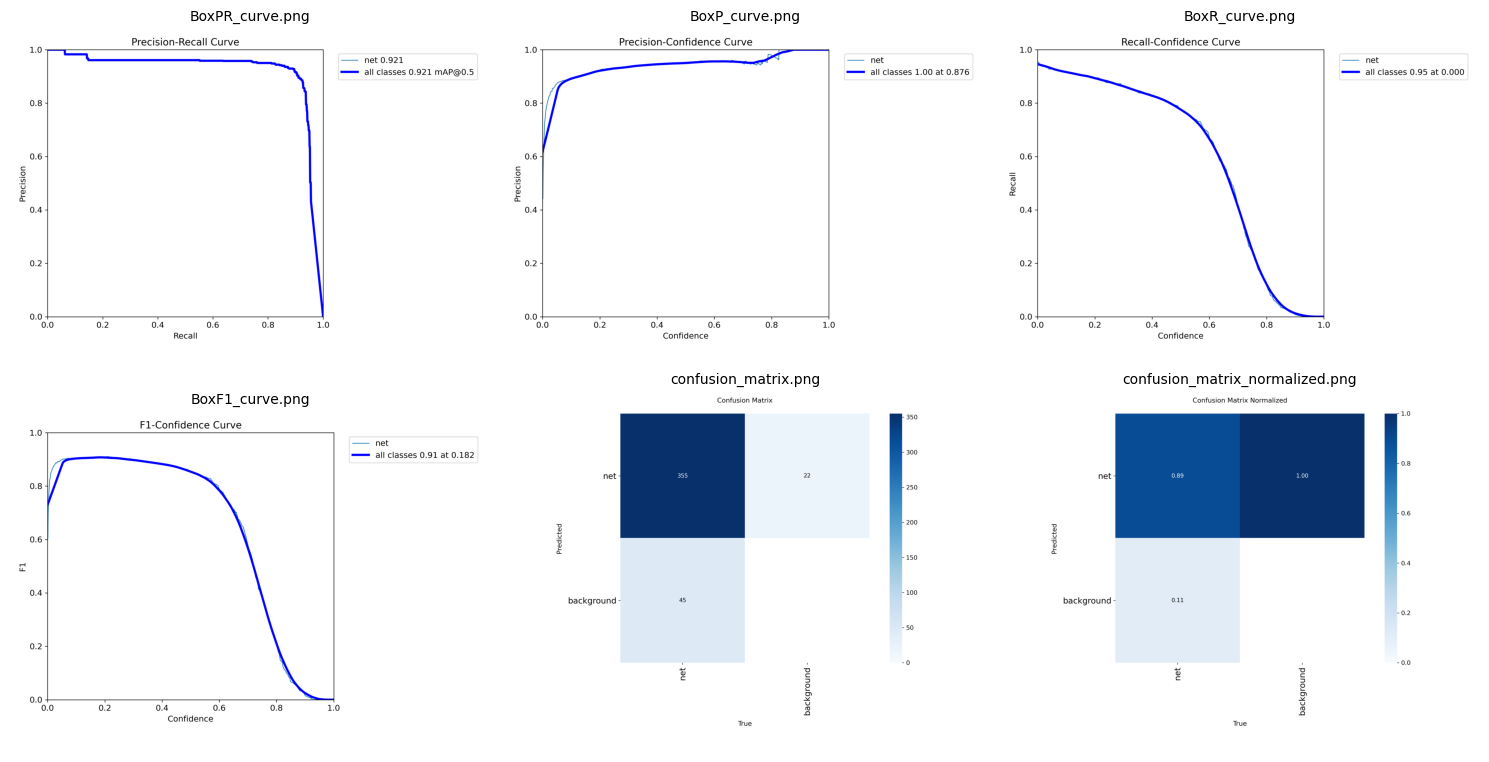

In [4]:
from utils.evaluation_utils import plot_evaluation_metrics

%matplotlib inline

run_dir = "../runs_aquayolo/EVAL_net_sonar_adamW_1280_verysafe"

plot_evaluation_metrics(run_dir)

### Show predictions

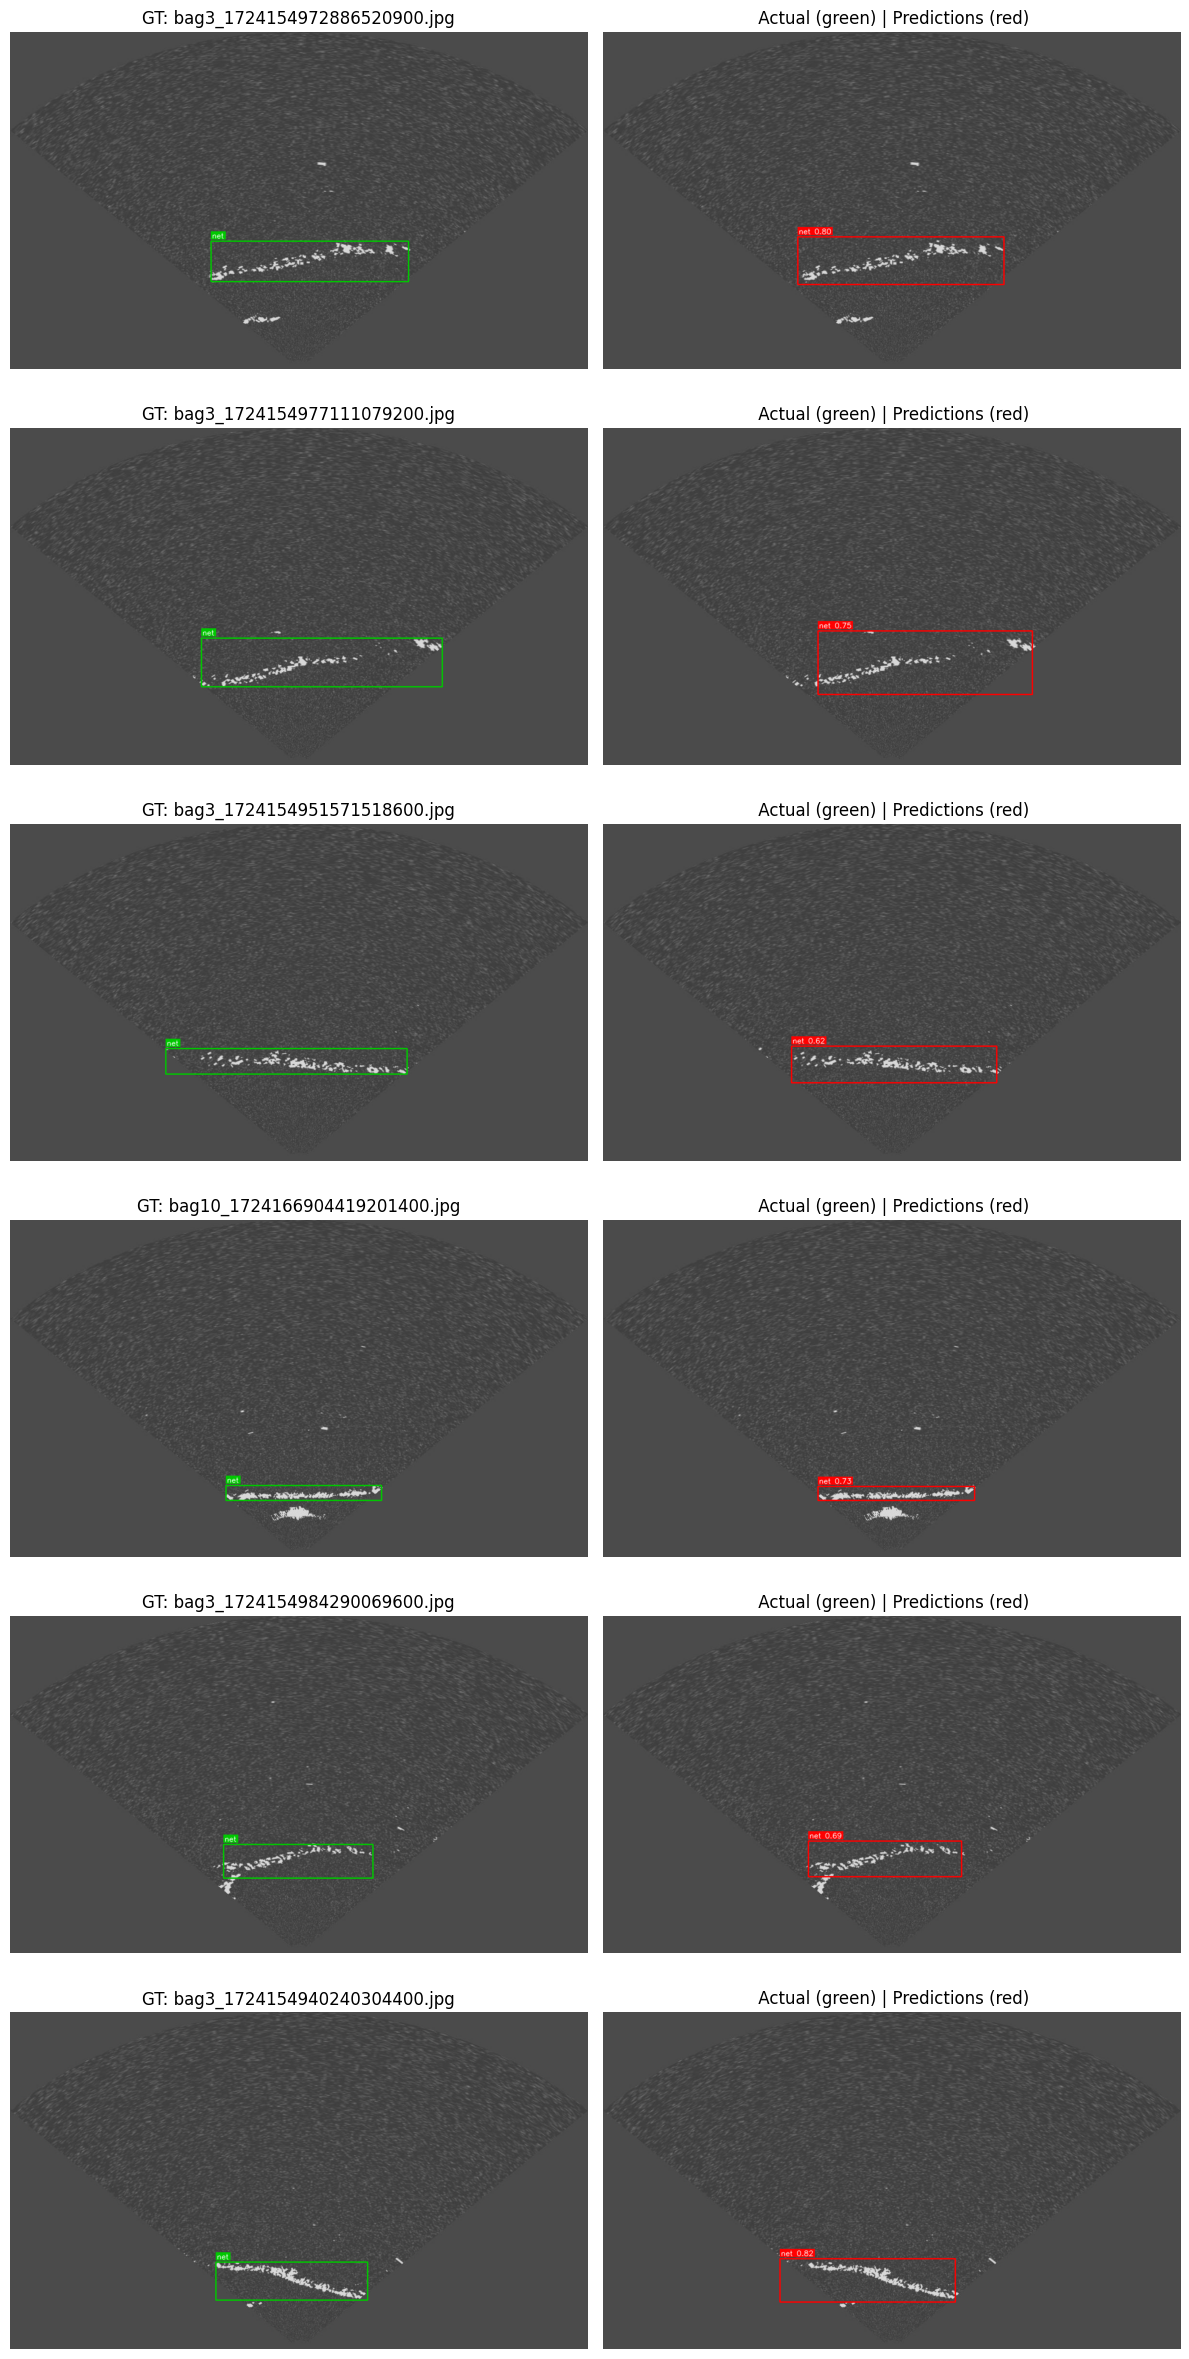

In [8]:
from utils.evaluation_utils import plot_yolo_predictions_samples

plot_yolo_predictions_samples(
    images_dir="../../solaqua/data/net_sonar/images/test",
    labels_dir="../../solaqua/data/net_sonar/labels/test",
    weights="../runs_aquayolo/net_sonar_SGD_1280_lightaug/weights/best.pt",
    num_samples=6,
    conf_thres=0.5,
    imgsz=1280
)
